## KAGGLE IMAGE RECONSTRUCTION CHALLENGE

### Group No. 26:

Pranav Nyati

Pranav Mehrotra

Rahul Chugh

Aninidita Mandal


## Imports and GPU Configurations

In [2]:
import tensorflow as tf
from keras.models import load_model

import os
import time
import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython import display
import glob 
import csv
import random


2023-04-16 21:33:55.144799: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:33:55.448896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:33:55.450329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 21:33:56.429567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

2023-04-16 21:33:59.103292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 21:33:59.103641: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Model Training Pipeline

## (A) PREPROCESSING 

#### IMAGE AND DATALOADER PARAMETERS


In [10]:
random.seed(42)

# PATH = "/kaggle/input/photo-reconstruction/photo-reconstruction/"
PATH = "./photo-reconstruction/"

''' Data Loader Parameters'''
BUFFER_SIZE = 1000
BATCH_SIZE = 1


''' Image Parameters '''
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_OUTPUT_CHANNELS = 3


#### DATA LOADER AND PRE-PROCESSING FUNCTIONS

In [11]:
def load(image_path):
    
    if isinstance(image_path, tf.Tensor):
        new_path = tf.strings.regex_replace(image_path, "Masked_Train", "Unmasked_Train")
    else:
        new_path = image_path.replace("Masked_Train", "Unmasked_Train")
        
    # Read the correct (masked) image
    image = tf.io.read_file(image_path)
    masked_image = tf.image.decode_jpeg(image)
    
    # Read the correct (unmasked) image
    image = tf.io.read_file(new_path)
    unmaksed_image = tf.image.decode_jpeg(image)
    
    # Convert the image to float values
    masked_image = tf.cast(masked_image, tf.float32)
    unmaksed_image = tf.cast(unmaksed_image, tf.float32)
    
    return masked_image, unmaksed_image


# function to resize the image
def resize_image(masked_image, unmasked_image, height, width):
    
    masked_image = tf.image.resize(masked_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    unmasked_image = tf.image.resize(unmasked_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return masked_image, unmasked_image

# function to randomly crop the masked and unmasked images (same cropping applied to both) for training
def random_crop(masked_image, unmasked_image):
    
    stacked_image = tf.stack([masked_image, unmasked_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, NUM_OUTPUT_CHANNELS])
    
    return cropped_image[0], cropped_image[1]

# function to normalize the masked and unmasked images (same normalization applied to both) for training
# Both the masked and unmasked images are normalized to the range [-1, 1]
def normalize(masked_image, unmasked_image):
    
    masked_image = (masked_image / 127.5) - 1
    unmasked_image = (unmasked_image / 127.5) - 1
    
    return masked_image, unmasked_image


In [14]:
@tf.function
def random_jitter(masked_image, unmasked_image):
    
    # Resize to 286 x 286 x 3, and then randomly crop to 256 x 256 x 3
    masked_image, unmasked_image = resize_image(masked_image, unmasked_image, 286, 286)
    
    masked_image, unmasked_image = random_crop(masked_image, unmasked_image)
    
    # if tf.random.uniform(()) > 0.5:
    #     # Random mirroring
    #     masked_image = tf.image.flip_left_right(masked_image)
    #     unmasked_image = tf.image.flip_left_right(unmasked_image)
    
    return masked_image, unmasked_image

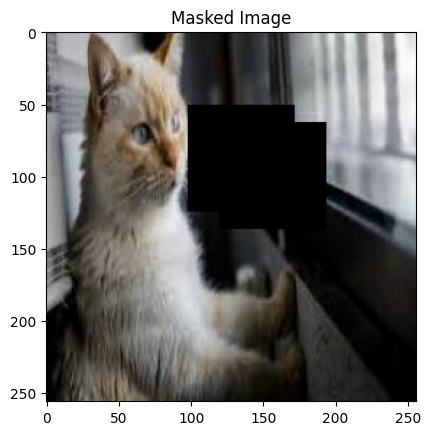

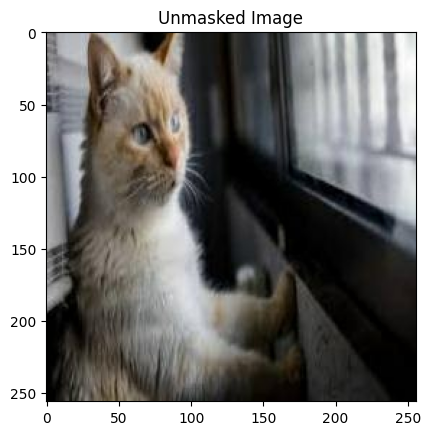

In [16]:
masked,unmasked = load(PATH + 'Dataset/Training_Data/Cat/Masked_Train/Cat-Train (10).jpeg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.title("Masked Image")
plt.imshow(masked / 255.0)

plt.figure()
plt.title("Unmasked Image")
plt.imshow(unmasked / 255.0)

#### DATA AUGMENTATION FUNCTIONS (ROTATIONS AND FLIPS) TO INCREASE TRAIN SET FOR THE MODEL

In [17]:
def load_image_train(image_path):
    
    augmented_images = {}
    
    # The masked image is loaded here (as given in training data)
    masked_image, unmasked_image = load(image_path)
    masked_image_orig, unmasked_image_orig = random_jitter(masked_image, unmasked_image)
    masked_image_orig, unmasked_image_orig = normalize(masked_image_orig, unmasked_image_orig)
    
    # Apply 90 degree rotation to the unmasked image
    masked_image_90 = tf.image.rot90(masked_image, k=1)
    unmasked_image_90 = tf.image.rot90(unmasked_image, k=1)
    masked_image_90 , unmasked_image_90 = random_jitter(masked_image_90, unmasked_image_90)
    masked_image_90, unmasked_image_90 = normalize(masked_image_90, unmasked_image_90)
    
    # Apply 180 degree rotation to the unmasked image
    masked_image_180 = tf.image.rot90(masked_image, k=2)
    unmasked_image_180 = tf.image.rot90(unmasked_image, k=2)
    masked_image_180 , unmasked_image_180 = random_jitter(masked_image_180, unmasked_image_180)
    masked_image_180, unmasked_image_180 = normalize(masked_image_180, unmasked_image_180)
    
    # Apply 270 degree rotation to the unmasked image
    masked_image_270 = tf.image.rot90(masked_image, k=3)
    unmasked_image_270 = tf.image.rot90(unmasked_image, k=3)
    masked_image_270 , unmasked_image_270 = random_jitter(masked_image_270, unmasked_image_270)
    masked_image_270, unmasked_image_270 = normalize(masked_image_270, unmasked_image_270)
    
    # Apply horizontal flip to the unmasked image
    masked_image_flip = tf.image.flip_left_right(masked_image)
    unmasked_image_flip = tf.image.flip_left_right(unmasked_image)
    masked_image_flip , unmasked_image_flip = random_jitter(masked_image_flip, unmasked_image_flip)
    masked_image_flip, unmasked_image_flip = normalize(masked_image_flip, unmasked_image_flip)
    
    
    augmented_images[0] = (masked_image_orig, unmasked_image_orig)
    augmented_images[1] = (masked_image_90, unmasked_image_90)
    augmented_images[2] = (masked_image_180, unmasked_image_180)
    augmented_images[3] = (masked_image_270, unmasked_image_270)
    augmented_images[4] = (masked_image_flip, unmasked_image_flip)
    
    return augmented_images

In [18]:
def load_image_test(image_path):
    
    # The masked image is loaded here (as given in testing data)
    masked_image, unmasked_image = load(image_path)
    masked_image, unmasked_image = resize_image(masked_image, unmasked_image, IMG_HEIGHT, IMG_WIDTH)
    masked_image, unmasked_image = normalize(masked_image, unmasked_image)
    
    return masked_image

#### LOADING THE TRAIN DATA (ALONG WITH APPLYING IMAGE AUGMENTATIONS)

In [19]:
train_path = [PATH + 'Dataset/Training_Data/Cat/Masked_Train/*.jpg',
              PATH + 'Dataset/Training_Data/Cat/Masked_Train/*.jpeg',
              PATH + 'Dataset/Training_Data/Cat/Masked_Train/*.png',
              PATH + 'Dataset/Training_Data/Dog/Masked_Train/*.jpg',
              PATH + 'Dataset/Training_Data/Dog/Masked_Train/*.jpeg',
              PATH + 'Dataset/Training_Data/Dog/Masked_Train/*.png',
              PATH + 'Dataset/Training_Data/Elephant/Masked_Train/*.jpg',
              PATH + 'Dataset/Training_Data/Elephant/Masked_Train/*.jpeg',
              PATH + 'Dataset/Training_Data/Elephant/Masked_Train/*.png',
              PATH + 'Dataset/Training_Data/Tiger/Masked_Train/*.jpg',
              PATH + 'Dataset/Training_Data/Tiger/Masked_Train/*.jpeg',
              PATH + 'Dataset/Training_Data/Tiger/Masked_Train/*.png']

train_files = tf.data.Dataset.list_files(train_path)
train_dataset_augmnt = train_files.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# print(len(train_dataset_augmnt))

## Split the train dataset into 5 parts based on the different augmentations applied to the unmasked image
train_dataset_augmnt_0 = train_dataset_augmnt.map(lambda x: x[0])
train_dataset_augmnt_1 = train_dataset_augmnt.map(lambda x: x[1])
train_dataset_augmnt_2 = train_dataset_augmnt.map(lambda x: x[2])
train_dataset_augmnt_3 = train_dataset_augmnt.map(lambda x: x[3])
train_dataset_augmnt_4 = train_dataset_augmnt.map(lambda x: x[4])

# print(type(train_dataset_augmnt))

train_dataset_total = train_dataset_augmnt_0
train_dataset_total = train_dataset_total.concatenate(train_dataset_augmnt_1)
train_dataset_total = train_dataset_total.concatenate(train_dataset_augmnt_2)
train_dataset_total = train_dataset_total.concatenate(train_dataset_augmnt_3)
train_dataset_total = train_dataset_total.concatenate(train_dataset_augmnt_4)

train_dataset_total = train_dataset_total.shuffle(BUFFER_SIZE)
train_dataset_total = train_dataset_total.batch(BATCH_SIZE)

"""
    Each training image has now 4 more augmented images.
    So total 5 images per training image.
    Therefore, total number of training examples becomes 5 times.
    (1750*5)*4 = 35000
"""

print(train_dataset_total)
print("\nTotal number of training examples after augmentation: ", len(train_dataset_total))



<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

Total number of training examples after augmentation:  35000


## (B) PIX-TO-PIX MODEL ARCHITECTURE 

#### DOWNSAMPLING AND UPSAMPLING LAYER DEFINITIONS

In [10]:
def downsample(filters, kernel_size, stride=2, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, kernel_size, strides=2, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=strides,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

#### GENERATOR ARCHITECTURE



In [11]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, 2, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4, 2),  # (batch_size, 64, 64, 128)
        downsample(256, 4, 2),  # (batch_size, 32, 32, 256)
        downsample(512, 4, 2),  # (batch_size, 16, 16, 512)
        downsample(512, 4, 2),  # (batch_size, 8, 8, 512)
        downsample(512, 4, 2),  # (batch_size, 4, 4, 512)
        downsample(512, 4, 2),  # (batch_size, 2, 2, 512)
        downsample(512, 4, 2),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, 2,apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, 2,apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, 2,apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4, 2),  # (batch_size, 16, 16, 1024)
        upsample(256, 4, 2),  # (batch_size, 32, 32, 512)
        upsample(128, 4, 2),  # (batch_size, 64, 64, 256)
        upsample(64, 4, 2),  # (batch_size, 128, 128, 128)
        
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(NUM_OUTPUT_CHANNELS,
                                           4,
                                           strides=2,
                                           padding="same",
                                           kernel_initializer=initializer,
                                           activation="tanh")  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# generator = Generator()

#### VISUALISE THE GENERATOR ARCHITECTURE

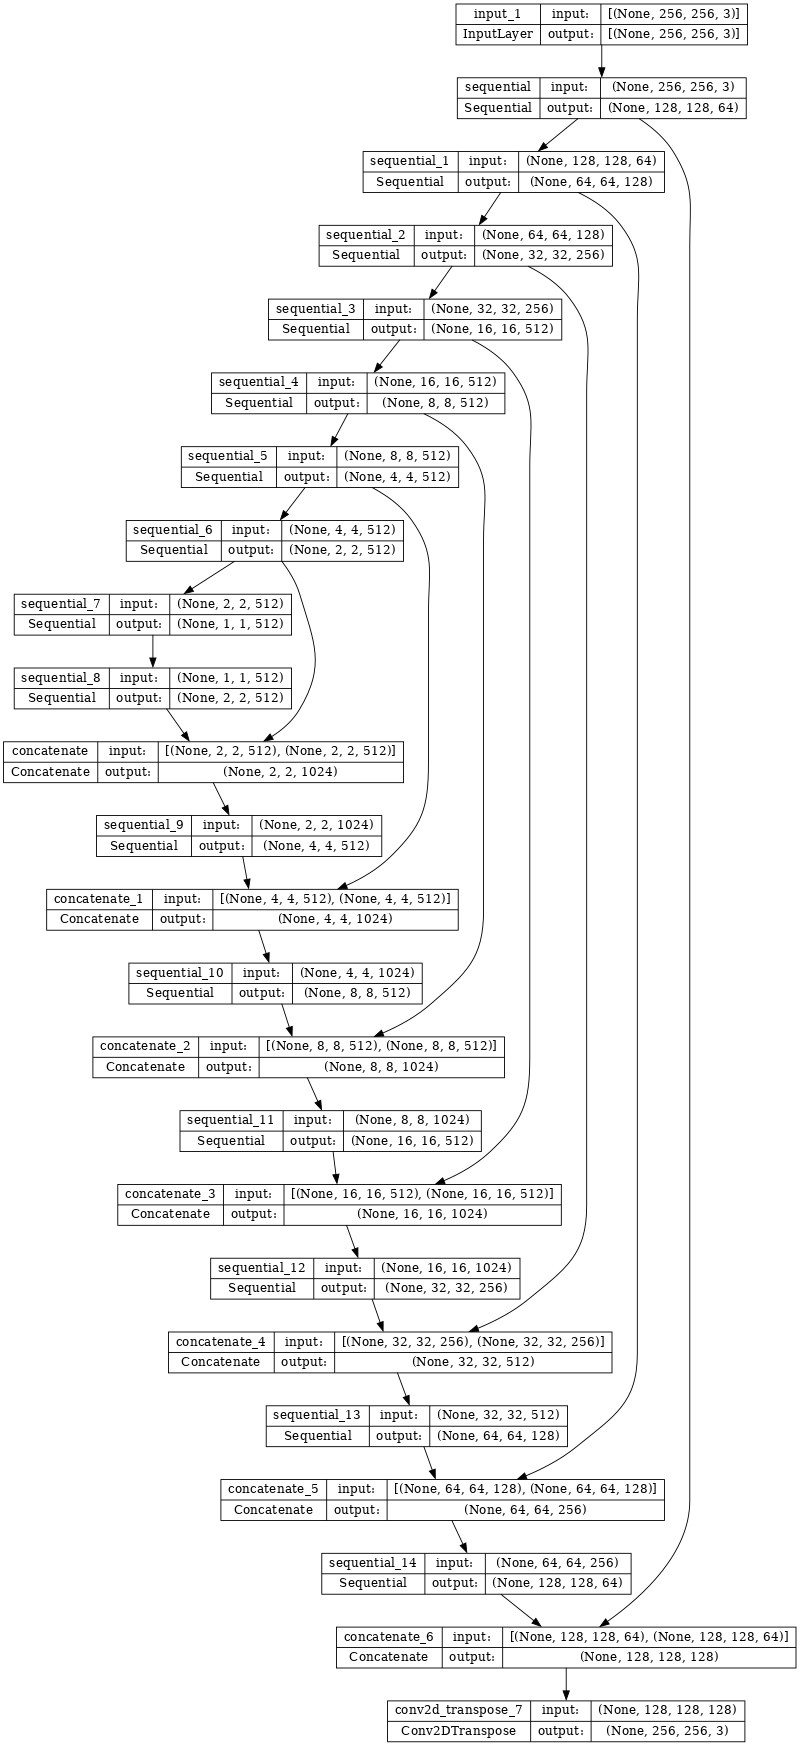

In [12]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

#### GENERATOR LOSS

In [13]:
LAMBDA = 1000   # WEIGHT FOR L1 LOSS (A HYPERPARAMETER)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output) # GAN LOSS BETWEEN GENERATED IMAGE AND 1'S

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))  # L1 LOSS BETWEEN TARGET IMAGE AND IMAGE GENERATED BY GENERATOR
    
    # TOTAL LOSS is a weighted sum of GAN LOSS and L1 LOSS
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

#### TEST THE GENERATOR's OUTPUT

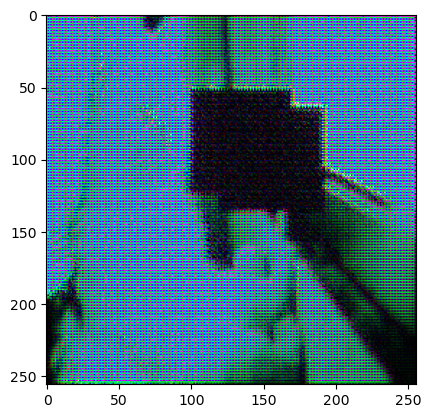

In [17]:
gen_output = generator(masked[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

#### DISCRIMINATOR ARCHITECTURE

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, 2, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4, 2)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4, 2)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

#### VISUALISE THE DISCRIMINATOR ARCHITECTURE

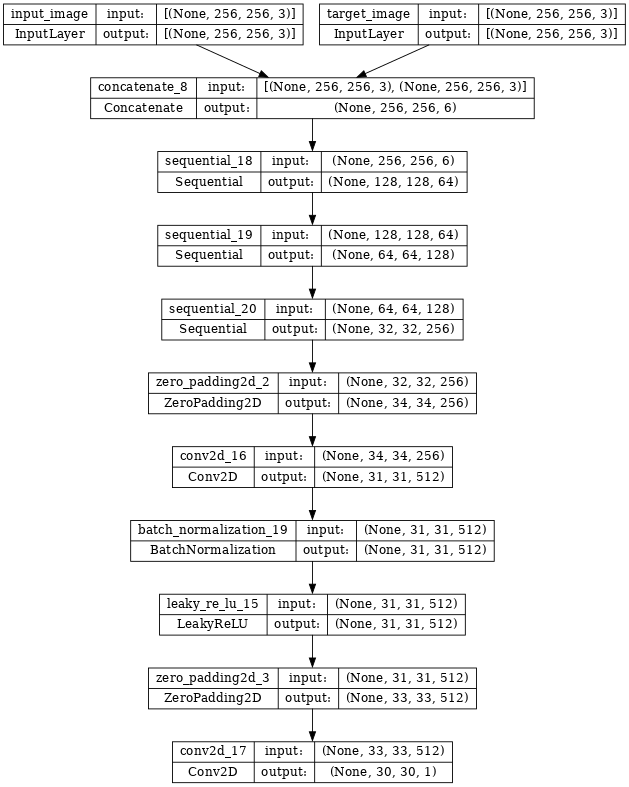

In [19]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

#### DISCRIMINATOR LOSS

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    # CALCULATE THE LOSS BETWEEN THE REAL IMAGE (UNMASKED) AND ALL 1's MATRIX
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    # CALCULATE THE LOSS BETWEEN THE GENERATED IMAGE (MASKED) AND ALL 0's MATRIX
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    # TOTAL LOSS IS THE WEIGHTED SUM OF THE TWO LOSSES
    total_disc_loss = real_loss + (LAMBDA*generated_loss)

    return total_disc_loss


#### TEST THE DISCRIMINATOR's OUTPUT

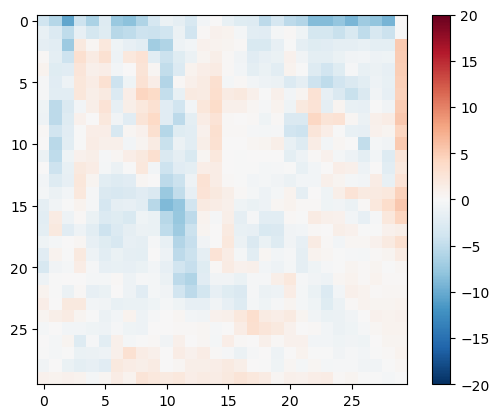

In [21]:
disc_out = discriminator([masked[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


## (C) TRAINING LOOP

#### INITIALIZING OPTIMIZER




In [22]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


#### GENERATE IMAGE FUNC

In [33]:
def generate_images(model, test_input):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(8, 8))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image (Masked)', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  

#### TRAINING STEP

In [24]:
# SAVE THE CHECKPOINTS OF THE MODEL AT REGULAR INTERVALS
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

@tf.function
def train_step(input_image, target, step, model):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = model(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                      model.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                           discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                      model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                          discriminator.trainable_variables))

    # For maintaining the losses in the logs
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
    
    return gen_total_loss

#### FIT FUNCTION (To Train the Model on TRAINING SET)

In [28]:
def fit(train_ds, steps, model):
    
    itrn_nums = []
    train_loss_vals = []
    
    example_input, example_target = next(iter(train_ds.take(1)))
    start = time.time()
    
    
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        
        if (step) % 1000 == 0:  #  Display the time taken for every 1000th step
            
#             display.clear_output(wait=True)
            if step != 0:
                print(f"\nTime taken for 1000 steps: {time.time()-start:.2f} sec\n")

            start = time.time()
            
#             generate_images(model, example_input, example_target)
            print(f"Step: {step//1000}k")
            
        # Training step
        train_loss = train_step(input_image, target, step=step,model=model)     # calculate the train loss from train_step at each step
        
            
        if (step) % 500 == 0:
            
            itrn_nums.append(step)
            train_loss_vals.append(train_loss)
            
            # generate_images(model, example_input, example_target)
            
            # print the iteration number and the loss
            print("Iteration: {}, Loss: {}".format(step, train_loss))
            

        # Save (checkpoint) the model every 10k steps
        if (step + 1) % 10000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
    return itrn_nums, train_loss_vals

#### IMPORT A PRETRAINED VERSION (SAVED WEIGHTS OF MODEL , IF ANY)

In [29]:
# MODEL_PATH = 'generator_180k.h5'

# my_model = load_model(MODEL_PATH)
# my_model.summary()

#### CALL TO FIT FUNCTION TO TRAIN THE MODEL

In [30]:
NUM_STEPS = 170000

MY_MODEL = generator
# MY_MODEL = my_model

# MY_MODEL.summary()

In [31]:
itrn_nums , train_loss_vals = fit(train_ds= train_dataset_total, steps= NUM_STEPS,model= MY_MODEL) 

Step: 0k


2023-04-15 11:20:58.002264: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Iteration: 0, Loss: 471.1605224609375
Iteration: 500, Loss: 121.9742202758789

Time taken for 1000 steps: 65.75 sec

Step: 1k
Iteration: 1000, Loss: 126.25149536132812
Iteration: 1500, Loss: 163.10398864746094

Time taken for 1000 steps: 54.16 sec

Step: 2k
Iteration: 2000, Loss: 116.53311920166016
Iteration: 2500, Loss: 115.32080078125

Time taken for 1000 steps: 54.03 sec

Step: 3k
Iteration: 3000, Loss: 87.68411254882812
Iteration: 3500, Loss: 100.32198333740234

Time taken for 1000 steps: 54.29 sec

Step: 4k
Iteration: 4000, Loss: 105.61638641357422
Iteration: 4500, Loss: 84.68486785888672

Time taken for 1000 steps: 53.94 sec

Step: 5k
Iteration: 5000, Loss: 113.83819580078125
Iteration: 5500, Loss: 77.09760284423828

Time taken for 1000 steps: 53.74 sec

Step: 6k
Iteration: 6000, Loss: 90.31446838378906
Iteration: 6500, Loss: 177.39694213867188

Time taken for 1000 steps: 55.41 sec

Step: 7k
Iteration: 7000, Loss: 68.12156677246094
Iteration: 7500, Loss: 67.84562683105469

Time t

#### PLOT THE TRAINING LOSS VS NO OF ITRNS CURVE 

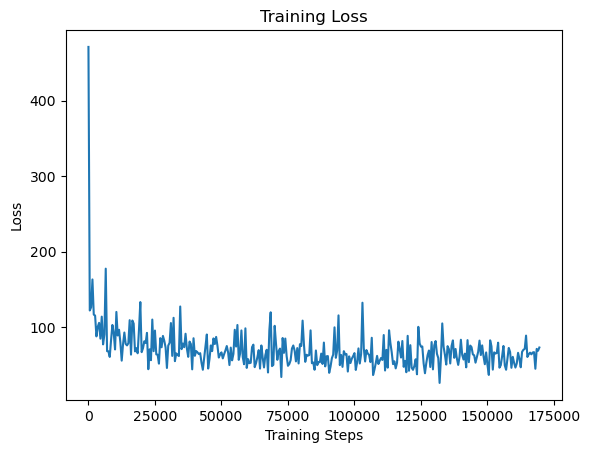

In [32]:
plt.plot(itrn_nums,train_loss_vals)
plt.title('Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.show()

#### SAVE THE TRAINED MODEL (in the .h5 format)

In [34]:

# save the model
MY_MODEL.save('gen_170_augmented.h5') 

## (D) INFERENCE ON TEST DATA

#### LOAD THE MODEL (.h5 file) FOR INFERENCE

In [21]:
MODEL_PATH = 'gen_170_augmented.h5'
my_model = load_model(MODEL_PATH)

my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

#### LOADING  THE TEST DATA

In [22]:
# Define the file path patterns for the images

# Bounding box sizes (75 * 75)
BOUNDING_SIZE = 75

def test_dataloader(test_path):
# Create a list of file paths
    file_paths = []
    for pattern in test_path:
        file_paths.extend(glob.glob(pattern))

    # Sort the file paths Numerically
    file_paths = sorted(file_paths)
    # Load the images into numpy arrays and store in a DataFrame
    image_data = {}
    for file_path in file_paths:
        img = load_image_test(file_path)
        # Trim the file path to just the file name
        file_path = file_path.split('/')[-1]
        image_data[file_path] = img

    print("Loaded {} images".format(len(image_data)))
    
    return image_data

In [23]:
test_path = [PATH + 'Dataset/Testing_Data/*.jpg',PATH + 'Dataset/Testing_Data/*.jpeg',PATH + 'Dataset/Testing_Data/*.png']

image_data = test_dataloader(test_path)


Loaded 200 images


#### READ THE "masked_info.csv" FOR TEST DATA INTO A DATAFRAME

In [24]:
TEST_CSV_PATH = PATH + 'Dataset/Testing_Data/masked_info.csv'

df = pd.read_csv(TEST_CSV_PATH)
df.head()

Unnamed: 0                    filename  box1_row  box1_col  box2_row   
0           0           Tiger (1024).jpeg        58        27       104  \
1           1  Elephant-Train (1195).jpeg        92        38        98   
2           2            Tiger (980).jpeg        12       116        42   
3           3  Elephant-Train (1842).jpeg         2        77       174   
4           4       Dog-Train (1753).jpeg        52        75        84   

   box2_col  
0        15  
1        94  
2        33  
3       174  
4       160

#### FUNCTION FOR CREATING SUBMISSION CSV

In [25]:
# Create a new csv file for predictions
import csv

with open('./predictions_170k_lambda_1000.csv', 'w') as csvfile:
    fieldnames = ['filename_box_pixel','Value']
    writer = csv.writer(csvfile)
    writer.writerow(fieldnames)
    # Iterate through the dataframe and apply predictions to the images
    for index, row in df.iterrows():
        # Get the image
        img = image_data[row['filename']]
        img = tf.expand_dims(img, 0)
        
        # Get the bounding boxes
        bounding_boxes = [[row['box1_row'], row['box1_col']],[row['box2_row'], row['box2_col']]]
        
        prediction = my_model(img, training=True)
        # preds = np.array(prediction[0])
        # print(type(preds))
        # print(preds.shape)
        # preds = preds*0.5 + 0.5
        # preds = preds*255
        # preds = preds.astype(np.uint8)

        # image = Image.fromarray(preds)
        # image.save('./GAN_Predictions/' + row['filename'])
        # plt.figure(figsize=(15, 15))
        # title = ['Input Image', 'Predicted Image']
        # display_list = [img[0], prediction[0]]
        # for i in range(2):
        #     plt.subplot(1, 3, i+1)
        #     plt.title(title[i])
        #     # Getting the pixel values in the [0, 1] range to plot.
        #     plt.imshow(display_list[i] * 0.5 + 0.5)
        #     plt.axis('off')
        # plt.show()
        # print(bounding_boxes)
        preds = np.array(prediction[0])
        preds = preds*0.5 + 0.5
        # print(preds.shape)
        out_str = row['filename']
        for k in range(2):
            temp_str = out_str + "_box" + str(k+1)
            # Get the pixel values of the bounding boxes
            for i in range(BOUNDING_SIZE):
                x = bounding_boxes[k][0] + i
                temp_str1 = temp_str + '_' + str(x)
                for j in range(BOUNDING_SIZE):
                    y = bounding_boxes[k][1] + j
                    temp_str2 = temp_str1 + '_' + str(y)
                    for p in range(3):
                        temp_str3 = temp_str2 + '_' + str(p)
                        writer.writerow([temp_str3, preds[x][y][2-p]])
        print(row['filename'])


    

Tiger (1024).jpeg
Elephant-Train (1195).jpeg
Tiger (980).jpeg
Elephant-Train (1842).jpeg
Dog-Train (1753).jpeg
Cat-Train (1374).jpeg
Cat-Train (61).jpeg
Tiger (1037).jpeg
Tiger (1477).jpeg
Cat-Train (24).jpg
Elephant-Train (40).jpeg
Tiger (1115).jpeg
Elephant-Train (1127).jpeg
Cat-Train (1547).jpeg
Elephant-Train (1183).jpeg
Dog-Train (651).jpeg
Cat-Train (1387).jpeg
Tiger (2256).jpeg
Tiger (766).jpeg
Tiger (1353).jpeg
Dog-Train (43).jpeg
Elephant-Train (584).jpeg
Cat-Train (1576).jpeg
Elephant-Train (1761).jpeg
Dog-Train (1640).jpeg
Dog-Train (42).jpg
Dog-Train (151).jpeg
Dog-Train (1536).jpeg
Elephant-Train (216).jpeg
Tiger (1534).jpeg
Elephant-Train (633).jpeg
Cat-Train (760).jpeg
Cat-Train (687).jpeg
Cat-Train (1457).jpeg
Cat-Train (24).jpeg
Dog-Train (46).jpg
Elephant-Train (382).jpeg
Dog-Train (875).jpeg
Cat-Train (1525).jpeg
Elephant-Train (64).jpeg
Cat-Train (712).jpeg
Tiger (2000).jpeg
Cat-Train (1354).jpeg
Cat-Train (167).jpeg
Elephant-Train (461).jpeg
Cat-Train (1702).jpeg
C

#### VISUALIZE THE PREDICTIONS ON TEST DATA

2023-04-16 22:17:34.834426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]
2023-04-16 22:17:34.834755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]


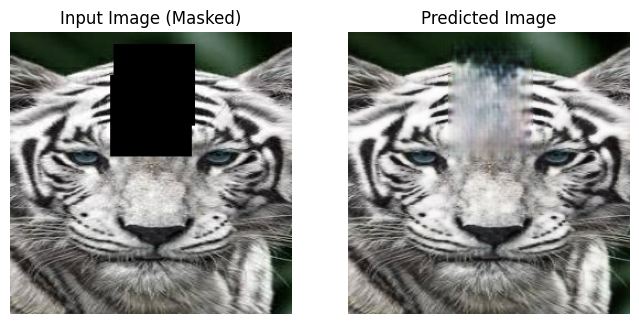

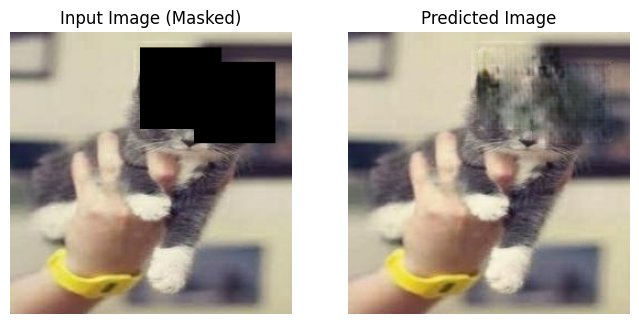

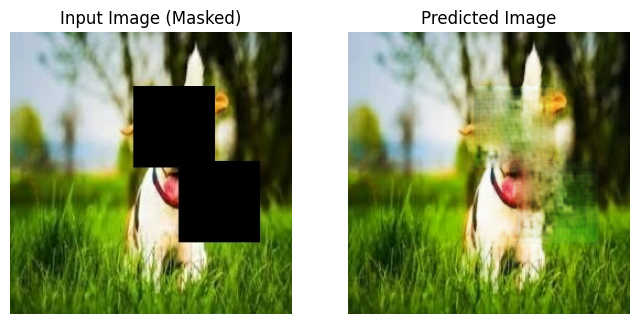

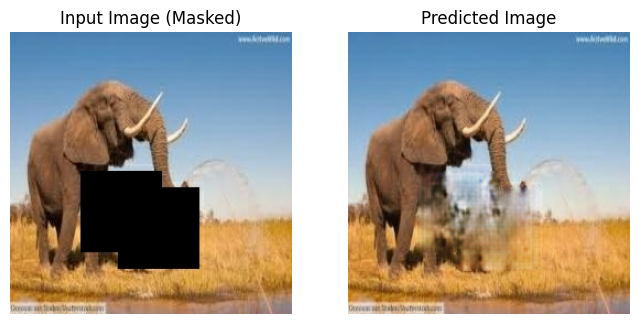

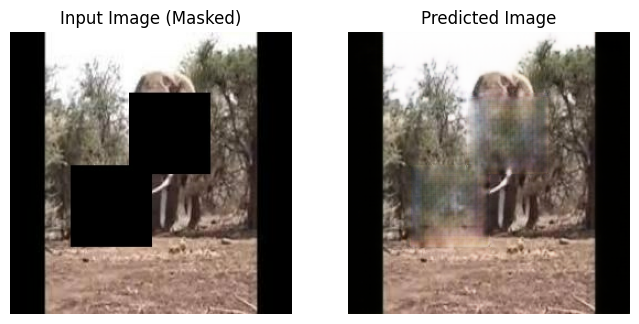

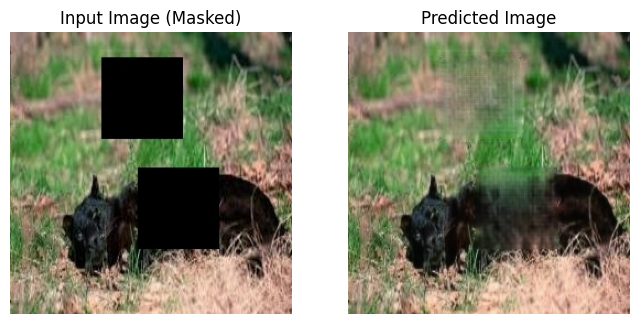

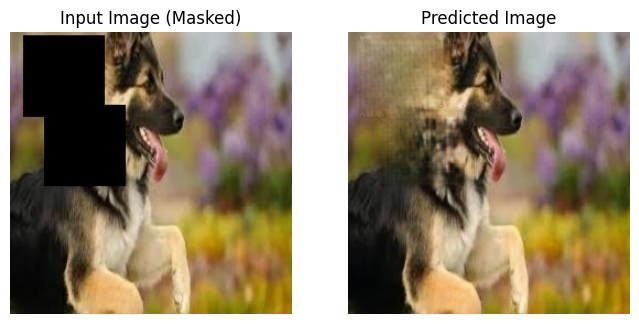

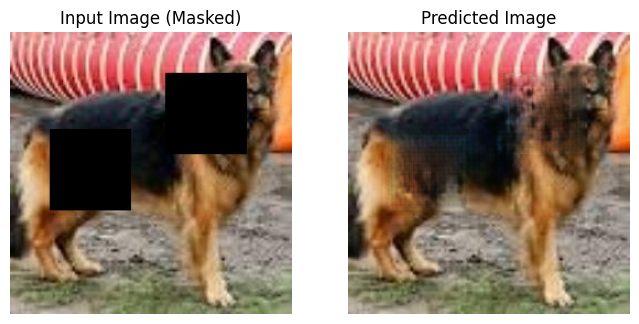

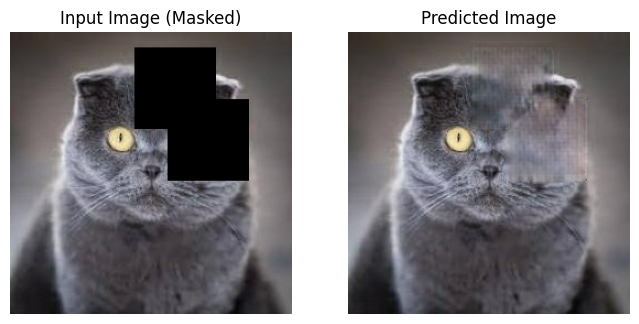

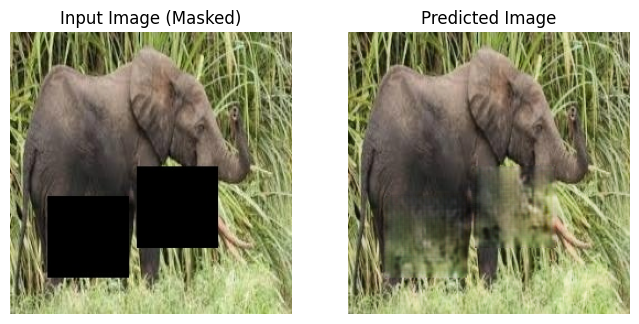

In [40]:

test_dataset = tf.data.Dataset.list_files(test_path)
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Run the trained model on a few examples from the test set
for inp in test_dataset.take(10):
  generate_images(my_model, inp)